<a href="https://colab.research.google.com/github/asidosaputra/rock-physics-modelling/blob/master/ProjectRPH_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install lasio

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import lasio

## Tahap 1 : Fungsi-fungsi pemodelan fisika batuan

Pemodelan yang dilakukan meliputi:
a. Model Solid(VRH) : Menghitung  modulus mineral
b. Model Kdry       :
c. Model Kuster-Toksoz : 

### 1.a Voigth, Reuss dan Hill Model
Voigth :
$${\displaystyle M_{v}=\sum _{i}^{N}f_{i}M_{i}}$$

Reuss :

$${\displaystyle {\frac {1}{M_{R}}}=\sum _{i}^{N}f_{i}{\frac {1}{M_{i}}}}{\displaystyle {\frac {1}{M_{R}}}=\sum _{i}^{N}f_{i}{\frac {1}{M_{i}}}}$$

Hill:
$$
{\displaystyle M_{VRH}={\frac {M_{V}+M_{R}}{2}}}$$

In [0]:
def voight_reuss_hill(M, f):
    """
    :param M: Input moduli tiap konstituen.
    :param f: Volume fraksi tiap konstituen.
    """
    v = np.sum(M*f)
    r = 1/np.sum(f/M)
    h = (v + r) / 2.
    return(v, r, h)

### 1.c Kuster Toksoz Model

Berikut persamaan Kuster-Toksoz(Gary Mavko, et.al, 1998):

$${\displaystyle (K^{*}-K){\frac {K+{\tfrac {4}{3}}\mu }{K^{*}+{\tfrac {4}{3}}\mu }}=\sum _{i}^{M}f_{i}(K_{i}-K)P_{i}}$$

$${\displaystyle (\mu ^{*}-K){\frac {\mu +\zeta }{\mu ^{*}+\zeta }}=\sum _{i}^{M}f_{i}(\mu _{i}-\mu )Q_{i}}$$

dimana : 

$${\displaystyle \zeta ={\frac {\mu (9K+8\mu )}{6(K+2\mu )}}}$$

dimana $P_{i}$ dan $Q_{i}$ sebagai berikut:

|Shape|Pi|Qi|
|---|-----|---|
|Sphere|$${\displaystyle {\frac {K+{\tfrac {4}{3}}\mu }{K_{i}+{\tfrac {4}{3}}\mu }}}$$|$${\displaystyle {\frac {K+{\tfrac {4}{3}}\mu }{K_{i}+{\tfrac {4}{3}}\mu }}}	{\displaystyle {\frac {\mu +\zeta }{\mu _{i}+\zeta }}}{\displaystyle {\frac {\mu +\zeta }{\mu _{i}+\zeta }}}$$|

In [0]:
def kuster_toksoz(Km, um,Ki, ui, xi, si, alpha=None):
    zeta = lambda K, u: u/6*(9*K + 8*u)/(K + 2*u)
    gamma = lambda K, u: u*(3*K + u)/(3*K + 7*u)
    beta = lambda K, u:u*(3*K + u)/(3*K + 4*u)

    if si == 'sphere':
        Pmi = (Km + 4/3*um)/(Ki + 4/3*um)
        Qmi = (um + zeta(Km, um))/(ui + zeta(Km, um))
    elif si == 'needle':    
        Pmi = (Km + um + 1/3*ui)/(Ki + um + 1/3*ui)
        Qmi = 1/5*(4*um / (um + ui) +
                   2*(um + gamma(Km, um))/(ui + gamma(Km, um)) +
                   (Ki + 4/3*um)/(Ki + um + 1/3*ui))
    elif si == 'disk':
        Pmi = (Km + 4/3*ui)/(Ki + 4/3*ui)
        if ui > 0:
            Qmi = (um + zeta(Ki, ui))/(ui + zeta(Ki, ui))
        else:
            Qmi = 0
    elif si == 'penny':
        Pmi = (Km + 4/3*ui)/(Ki + 4/3*ui + np.pi*alpha*beta(Km, um))
        Qmi = 1/5*(1 +
                   8*um / (4*ui + np.pi*alpha*(um + 2*beta(Km, um))) +
                   2*(Ki + 2/3*(ui + um)) /
                   (Ki + 4/3*ui + np.pi*alpha*beta(Km, um)))

    Kkt = (((Km + 4/3*um)*Km + 4/3*xi*(Ki - Km)*Pmi*um) /
           (Km + 4/3*um - xi*(Ki - Km)*Pmi))

    ukt = ((xi*(ui - um)*Qmi*zeta(Km, um) + (um + zeta(Km, um))*um) /
           (um + zeta(Km, um) - xi*(ui - um)*Qmi))

    return( Kkt, ukt)

1.d Plotting

In [0]:
def displaylog(well,curve, top_depth, bottom_depth):
    cols = len(curve)
    fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(15, 15), sharey=True)
    fig.subplots_adjust(top=0.85, wspace=0)

    # General setting for all axis
    for axes in ax:
        axes.set_ylim(top_depth, bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
    ax[0].set_ylabel('Depth[m]')
    
    for i,k in enumerate(curve):
        ax[i].plot(well[k], well['DEPTH'],color='b', linewidth=0.75)
        ax[i].set_xlabel(str(k))
        ax[i].grid(which='major', color='r', linestyle='-', alpha=0.35)

In [0]:
def vel(K, Mu, rho):
    vs = np.sqrt(Mu / rho)
    vp = np.sqrt((K + (4/3)*Mu)/ rho)

    return vp, vs

## Tahap II : Implementasi terhadap sumur 349-U1431E

2.a Read dan Plot sumur

['DEPTH', 'APLC', 'HCGR', 'HSGR', 'IDPH', 'IMPH', 'LCAL', 'PEFL', 'RHOM', 'SFLU', 'VP1', 'VP2']


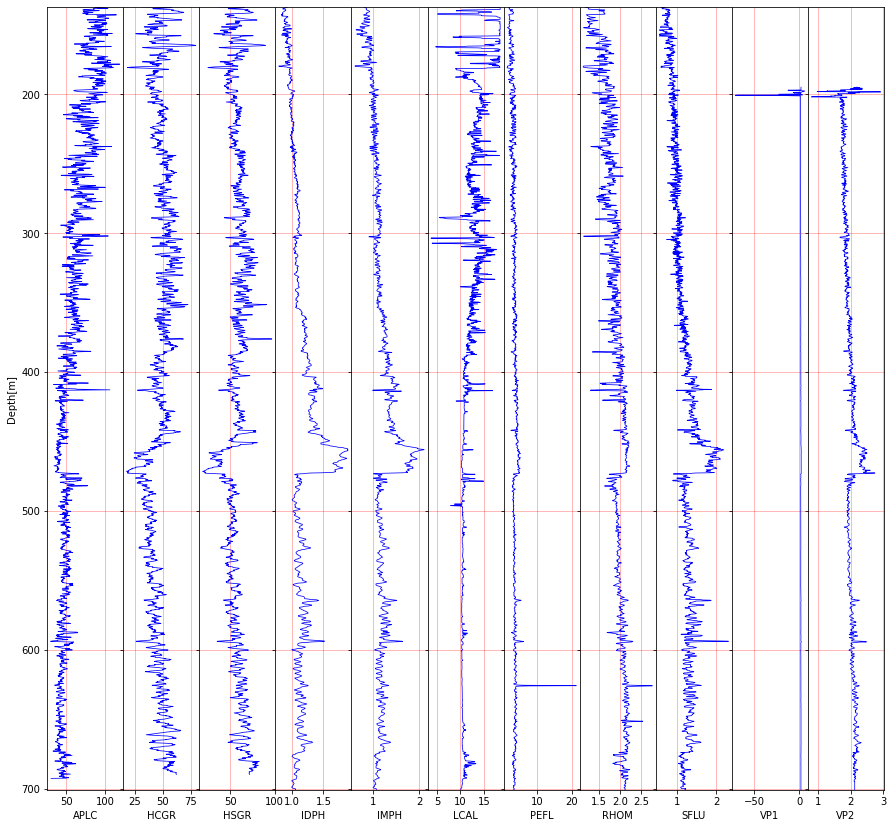

In [0]:
#01 Import Las
path_file = '/content/drive/My Drive/LAS File/1184-U1148.las'
well_01 = lasio.read(path_file)

print(well_01.keys())
#02 Ploting
curve = ['APLC', 'HCGR', 'HSGR', 'IDPH', 'IMPH', 'LCAL', 'PEFL', 'RHOM', 'SFLU', 'VP1', 'VP2']
top_depth, bottom_depth = min(well_01['DEPTH']), max(well_01['DEPTH'])
displaylog(well_01,curve, top_depth, bottom_depth)

### 2.a.1 Porosity fron neutron porosity
sumber : https://www.spec2000.net/12-phint.htm

In [0]:
phi_log = well_01['APLC']/100 - 0.1

### 2.b Pemodelan Solid Rock: VRH

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


<Figure size 432x288 with 0 Axes>

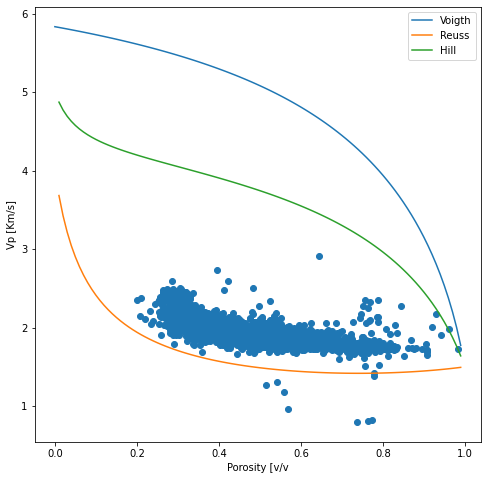

In [0]:
#Modulus mineral penyusun kerangka batuan berdasarkan data
K_cb = 63.7   ; Mu_cb = 31.7    #GPa            #Carbonate
K_qz =36.5    ; Mu_qz = 44    #GPa            #quartz
K_bi = 44.8   ; Mu_bi = 38.8  #GPa            #Silica
K_g = 2.25  ; Mu_g = 0      #GPa            #Gas

#Fraksi mineral
f_cb = 0.15
f_qz = 0.05
f_si = 0.8
s_g = 1

#Bulk Density
rho_qz=2.65
rho_bi=2.92
rho_cb=2.71
rho_g= 1

#Porosity
phi = np.arange(0, 1, 0.01)

#VRH Modell
K = np.array([K_cb, K_qz, K_bi, K_g])
Mu = np.array([Mu_cb, Mu_qz, Mu_bi, Mu_g])

plt.figure(1)
K_0v = []; M_0v = []; Vp0_v = []; Vs0_v = []
K_0r = []; M_0r = []; Vp0_r = []; Vs0_r = []
K_0h = []; M_0h = []; Vp0_h = []; Vs0_h = [] 

for i in range(len(phi)):
    f = np.array([f_cb*(1-phi[i]), f_qz*(1-phi[i]), f_si*(1-phi[i]), s_g*phi[i]])
    K_v, K_r, K_h= voight_reuss_hill(K, f)
    M_v, M_r, M_h= voight_reuss_hill(Mu, f)

    rho = rho_cb*(1 - phi[i]) * f_cb + rho_qz * (1-phi[i]) * f_qz +  rho_bi * (1-phi[i]) * f_si + rho_g * (phi[i]) * s_g
    vp_v, vs_v = vel(K_v, M_v, rho)
    vp_r, vs_r = vel(K_r, M_r, rho)
    vp_h, vs_h = vel(K_h, M_h, rho)
    
    K_0v.append(K_r)    ;M_0v.append(M_v)
    K_0r.append(K_v)    ;M_0r.append(M_r)
    K_0h.append(K_h)    ;M_0h.append(M_h)
    Vp0_v.append(vp_v)  ;Vs0_v.append(vs_v)
    Vp0_r.append(vp_r)  ;Vs0_r.append(vs_r)
    Vp0_h.append(vp_h)  ;Vs0_h.append(vs_h)

#plot template
plt.figure(figsize=(8, 8))
plt.plot(phi,Vp0_v, label='Voigth')
plt.plot(phi,Vp0_r, label='Reuss')
plt.plot(phi,Vp0_h, label='Hill')

#plot data sumur
plt.scatter(phi_log, well_01['VP2'])
plt.xlabel('Porosity [v/v')
plt.ylabel('Vp [Km/s]')
plt.legend()
plt.show()

### 2.c Kuster Toksoz Models

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


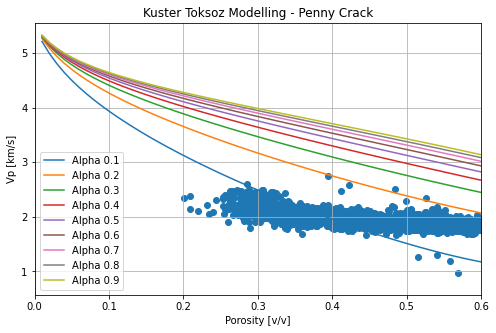

In [0]:
Km = np.array(K_0h) #K_mineral as hill
um = np.array(M_0h)

alpha = np.arange(0.1, 1, 0.1)
plt.figure(1, figsize=(8, 5))
for a in alpha:
    Kkt_pn, ukt_pn = kuster_toksoz(Km, um, K_g, 0, phi, si='penny', alpha = a)
    lb = 'Alpha ' + str(np.round(a, 1))
    rho = rho_cb*(1-phi)*f_cb +   rho_qz*(1-phi)*f_qz +  rho_si*(1-phi)*f_si + rho_g*(phi)*s_g
    vp_v, vs_v = vel(Kkt_pn, ukt_pn, rho)
    plt.plot(phi, vp_v, label=lb)
plt.scatter(phi_log, well_01['VP2'])
plt.title('Kuster Toksoz Modelling - Penny Crack')
plt.ylabel('Vp [km/s]')
plt.xlabel('Porosity [v/v]')
plt.xlim(0, 0.6)
plt.grid()
plt.legend()
plt.show()


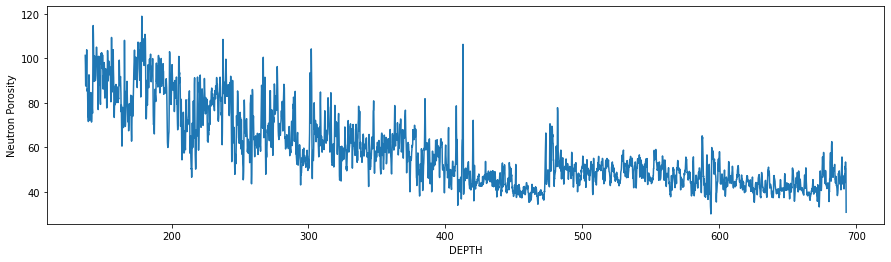

In [0]:
plt.figure(figsize=(15, 4))
plt.plot(well_01['DEPTH'], well_01['APLC'])
plt.xlabel('DEPTH')
plt.ylabel('Neutron Porosity')
plt.show()